In [1]:
import os
import math
import time
import pandas as pd
import numpy as np
import pyterrier as pt
import matplotlib.pyplot as plt

In [2]:
# Definimos algunas funciones

In [3]:
log2 = lambda x: log(x, 2)

In [4]:
def Unary(x):
    return (x-1)*'0'+'1'

In [5]:
def Binary(x, l = 1):
    s = '{0:0%db}' % l
    return s.format(x)

In [6]:
def Elias_Gamma_Coding(x):
    if(x == 0):
        return '0'
    #
    n = 1 + int(math.log2(x))
    b = x - 2**(int(math.log2(x)))
    l = int(math.log2(x))
    return Unary(n) + Binary(b, l)

In [7]:
def Elias_Gamma_Decoding(x):
    x = list(x)
    K = 0
    while True:
        if not x[K] == '0':
            break
        K = K + 1
    # Se leen K bits más desde '1'
    x = x[K:2*K+1]
    n = 0
    x.reverse()
    # Se convierte de binario a entero
    for i in range(len(x)):
        if x[i] == '1':
            n = n+math.pow(2, i)
    return int(n)

In [8]:
def Variable_Byte_Coding(n):
    finalBinary = ''

    if n < 127:     # Alcanza solo 1 byte
        binary = bin(n)[2:]
        # Si la longitud del binario es < 7, se agregan 0s a la izquierda.
        if len(binary) < 7:
            binary = '1' + '0' * (7 - len(binary)) + binary
        else:
            binary = '1' + binary
        #
        finalBinary = binary
    else:
        length = len(bin(n)[2:])
        # Convertir a binario
        binary = bin(n)[2:]
        # Se obtienen los 7 dígitos del binario y se le agrega un "1"
        lowerBits = int('1' + binary[length - 7:])
        # Se obtienen los bits "altos"
        higherBits = ''
        binary = binary[::-1]
        #
        for i in range(7, length, 7):         # Desde el 7mo bit del binario hasta el final, cada 7 bits.
            higherBits = binary[i:i + 7]
            higherBits = higherBits[::-1]
            if len(higherBits) < 8:
                higherBits = '0' * (8 - len(higherBits)) + higherBits
            # 
            finalBinary = higherBits + finalBinary
        #
        finalBinary += str(lowerBits)
    return finalBinary

---
### MAIN
---
#### Pruebas simples con Elias Gamma

In [9]:
n = 17

cn = Elias_Gamma_Coding(n)
cn

'000010001'

In [10]:
dn = Elias_Gamma_Decoding(cn)
dn

17

**Tarea 1: Probar desde 1 hasta n tal que Elias_Gamma_Coding(n) requiera más bits que Binary(n)**

### Pruebas simples con VByte

In [11]:
cn = Variable_Byte_Coding(n)
cn

'10010001'

In [12]:
cn = Variable_Byte_Coding(127)
cn

'11111111'

In [13]:
cn = Variable_Byte_Coding(128)
cn

'0000000110000000'

**Tarea 2: Calcular en qué valor ocurre el siguiente salto en bytes (de 2 a 3)**

### Ejemplo con Bit Packing

In [14]:
# Bit packing, cálculo de b (recordar que la lista no contiene los docIDs originales sino DGaps de éstos)
bits_header = 4
lista = [76, 53, 254, 55, 54, 48, 60, 212, 128, 37, 1, 1, 1, 2, 3, 1499, 220, 149, 121, 232]

In [15]:
# Lista completa
m = max(lista)
b = math.ceil(math.log2(m))
bits_totales_lista = m + b *len(lista)
print (f'Bit packing de la lista completa requiere {bits_totales_lista} bits')

Bit packing de la lista completa requiere 1719 bits


In [16]:
s = 6
bits_totales_bloques = 0
for i in range(0, len(lista), s):
  bloque = lista[i:i+s]
  m = max(bloque)
  b = math.ceil(math.log2(m))
  #
  print (bloque, "max: ", m, " - b: ", b)
  bits_bloque = bits_header + b * s
  bits_totales_bloques += bits_bloque
  #
#
print ()
#print ("Sin comprimir, las lista ocupa")
print (f'Con bloques de tamaño {s} se requieren {bits_totales_bloques} bits')

tasa   = bits_totales_lista / bits_totales_bloques
ahorro = 1 - bits_totales_bloques / bits_totales_lista

print (f'Tasa de compresion: {round(tasa, 2)}')
print (f'Ahorro            : {round(ahorro, 2)}')

[76, 53, 254, 55, 54, 48] max:  254  - b:  8
[60, 212, 128, 37, 1, 1] max:  212  - b:  8
[1, 2, 3, 1499, 220, 149] max:  1499  - b:  11
[121, 232] max:  232  - b:  8

Con bloques de tamaño 6 se requieren 226 bits
Tasa de compresion: 7.61
Ahorro            : 0.87


**Tarea 3: Calcular la tasa de compresión para s = [3, 8]**

### Comprimir posting del corpus 'vaswani'

In [17]:
if not pt.started():
    pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [18]:
dataset = pt.datasets.get_dataset("vaswani")

In [19]:
for i, d in enumerate(dataset.get_corpus_iter()):
    print (d)
    if (i > 3):
        break

{'docno': '1', 'text': 'compact memories have flexible capacities  a digital data storage\nsystem with capacity up to bits and random and or sequential access\nis described'}
{'docno': '2', 'text': 'an electronic analogue computer for solving systems of linear equations\nmathematical derivation of the operating principle and stability\nconditions for a computer consisting of amplifiers'}
{'docno': '3', 'text': 'electronic coordinate transformer  circuit details are given for\nthe construction of an electronic calculating unit which enables\nthe polar coordinates of a vector modulus and cosine or sine of the\nargument to be derived from those of a rectangular system of axes'}
{'docno': '4', 'text': 'the british computer society  report of a conference held in cambridge\njune'}
{'docno': '5', 'text': 'millimicrosecond digital computer logic  a system of fast pulse\nlogic is described which combines the efficiency of transformer coupled\nstages with digit delay tolerances approaching that

In [20]:
index_path = "./vaswani_index"
if os.path.exists(index_path):
    index = pt.IndexFactory.of(index_path+"/data.properties")
else:
    indexer  = pt.TRECCollectionIndexer(index_path, blocks=True)
    indexref = indexer.index(dataset.get_corpus())
    index = pt.IndexFactory.of(indexref)

In [21]:
print(index.getCollectionStatistics().toString())

Number of documents: 11429
Number of terms: 7756
Number of postings: 224573
Number of fields: 0
Number of tokens: 271581
Field names: []
Positions:   true



In [22]:
lex = index.getLexicon()

In [23]:
# Posting list del término ´x´
meta = index.getMetaIndex()
inv  = index.getInvertedIndex()
#
le = lex.getLexiconEntry("run")


list_docs  = []
list_freqs = []
# the lexicon entry is also our pointer to access the inverted index posting list
for posting in inv.getPostings(le):
    docno = meta.getItem("docno", posting.getId())
    #print("(%s, %d), " % (docno, posting.getFrequency()), end = '')
    list_docs.append(int(docno))
    list_freqs.append(int(posting.getFrequency()))
#
print (list_docs)
print (list_freqs) 

[948, 950, 2863, 3164, 3462, 3496, 4898, 4953, 5071, 5538, 5667, 5815, 6711, 6829, 6862, 6942, 6991, 7436, 7870, 8557, 8959, 9236, 9778, 9974, 10159, 10857]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2]


In [24]:
def compute_dgaps(docids):
    refval = docids[0]
    dgaps  = [refval]
    for cur in range(1, len(docids)):
        this_gap = docids[cur] - refval
        #print (cur, refval, docids[cur], this_gap)
        refval   = docids[cur]
        dgaps.append(this_gap)
    return dgaps

In [25]:
compute_dgaps(list_docs)

[948,
 2,
 1913,
 301,
 298,
 34,
 1402,
 55,
 118,
 467,
 129,
 148,
 896,
 118,
 33,
 80,
 49,
 445,
 434,
 687,
 402,
 277,
 542,
 196,
 185,
 698]

In [26]:
# Librería de codecs de compresión
from pyfastpfor import *

In [27]:
getCodecList()

['BP32',
 'copy',
 'fastbinarypacking16',
 'fastbinarypacking32',
 'fastbinarypacking8',
 'fastpfor128',
 'fastpfor256',
 'maskedvbyte',
 'newpfor',
 'optpfor',
 'pfor',
 'pfor2008',
 'simdbinarypacking',
 'simdfastpfor128',
 'simdfastpfor256',
 'simdgroupsimple',
 'simdgroupsimple_ringbuf',
 'simdnewpfor',
 'simdoptpfor',
 'simdpfor',
 'simdsimplepfor',
 'simple16',
 'simple8b',
 'simple8b_rle',
 'simple9',
 'simple9_rle',
 'simplepfor',
 'streamvbyte',
 'varint',
 'varintg8iu',
 'varintgb',
 'vbyte',
 'vsencoding']

In [28]:
def comprimir_lista(lista_in, mycodec):
    # Comprimir ' lista_in' 
    lista_size = len(lista_in)

    # Inicializar estructuras de datos. Se reserva memoria adicional por el 
    # caso en que los datos comprimidos ocupen más que los no comprimidos.
    # Para la compresión
    lista_comp   = np.zeros(lista_size + 1024, dtype = np.uint32, order = 'C')
    # Para la descompresión
    lista_decomp = np.zeros(lista_size, dtype = np.uint32, order = 'C')
    # Inicializar un codec (usando su nombre)
    codec = getCodec(mycodec)
    
    #
    start = time.time()
    # Comprimir
    lista_comp_size = codec.encodeArray(lista_in, lista_size, lista_comp, len(lista_decomp))
    compress_time = time.time() - start
    #
    start = time.time()
    # Descomprimir y chqequear (no) pérdida.
    assert(lista_size == codec.decodeArray(lista_comp, lista_comp_size, lista_decomp, lista_size))
    decompress_time = time.time() - start
    
    assert(np.all(lista_decomp == lista_in))
    
    # Calcular tasa de compresión
    tasa = float(lista_size) / lista_comp_size
    #
    
    return tasa, compress_time*1000, decompress_time*1000

In [29]:
mycodec = 'vbyte'

In [30]:
list_in = list_docs
tasa, ct, dt = comprimir_lista(list_in, mycodec)
print(f'Long. lista: {len(list_docs)}, codec *{mycodec}*, tasa de compresión {round(tasa, 2)}')

Long. lista: 26, codec *vbyte*, tasa de compresión 2.0


In [31]:
list_in = compute_dgaps(list_docs)
tasa, ct, dt = comprimir_lista(list_in, mycodec)
print(f'Long. lista: {len(list_docs)}, codec *{mycodec}*, tasa de compresión {round(tasa, 2)}')

Long. lista: 26, codec *vbyte*, tasa de compresión 2.36


**Tarea 4: Probar con listas de otros términos (más largas). Por ejemplo, 'electron'**

### Tradeoff tiempo/espacio

In [32]:
import random

n = 1000000
randomlist = random.sample(range(1, 100000000), n)
test_list = compute_dgaps(sorted(randomlist))

In [33]:
test_codecs = ['pfor', 'simdbinarypacking', 'vbyte', 'simdpfor']

In [34]:
test_tasa  = []
test_ctime = []  # Tiempo de compresión
test_dtime = []  # Tiempo de descompresión

for mycodec in test_codecs:
    tasa, ct, dt = comprimir_lista(test_list, mycodec)
    test_tasa.append(tasa)
    test_ctime.append(ct)
    test_dtime.append(dt)

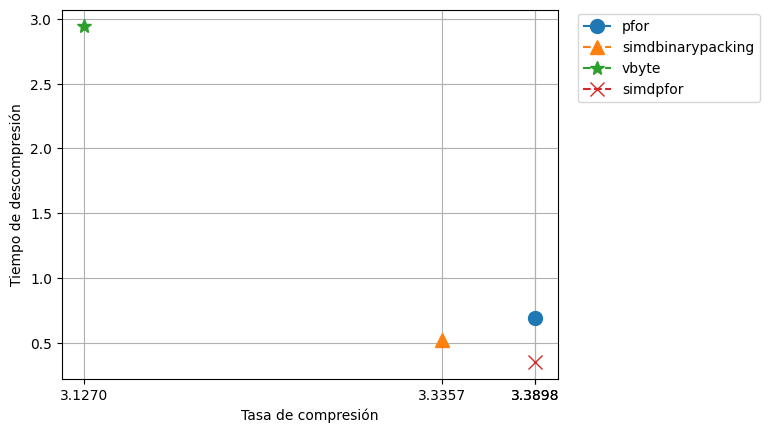

In [35]:
markers = ['o--', '^--','*--','x--']
for i, codec in enumerate(test_codecs):
    plt.plot(test_tasa[i], test_dtime[i], markers[i], markersize=10, label=test_codecs[i])
#
plt.grid()
plt.xlabel("Tasa de compresión")
plt.ylabel("Tiempo de descompresión")
#
locs, labels = plt.xticks(test_tasa)
plt.legend(loc=(1.04, 0.75))
plt.show()